In [4]:
import numpy as np
import torch

from models_monopoly import MAPPOAgent, RolloutBuffer, ppo_update
from Monopoly_Go.monopoly_go import monopoly_go_v0


num_episodes = 10_000
gamma = 0.99
lam = 0.95
batch_size = 128
lr = 1e-3

# Environment setup
env = monopoly_go_v0.env(render_mode="human")
env.reset()
sample_obs = env.observe("player_0")

obs_dim = sample_obs.shape[0]
act_dim = env.action_space("player_0").n
full_obs_dim = obs_dim # for centralized critic with 3 agents

In [5]:
def evaluate_ppo_agent_vs_random(agent, env_fn, eval_episodes=100, agent_idx=0, device="cpu"):
    """
    Evaluate a trained PPO agent against random opponents.

    Args:
        agent: Trained MAPPOAgent instance.
        env_fn: Function that returns a new PettingZoo env.
        eval_episodes: Number of evaluation episodes.
        agent_idx: Index of agent to evaluate (e.g., player_0 -> 0).
        device: Torch device.

    Returns:
        Win rate of the evaluated PPO agent.
    """
    wins = 0
    n_agents = 3  # adjust if needed

    for ep in range(eval_episodes):
        env = env_fn(render_mode=None)
        env.reset(seed=10_000 + ep)
        terminated = [False] * n_agents

        while not all(terminated):
            agent_i = env.curr_agent_index
            obs, _, term, _, info = env.last()

            if term:
                terminated[agent_i] = True
                env.step(None)
                continue

            mask = torch.tensor(info["action_mask"], dtype=torch.bool, device=device)

            if agent_i == agent_idx:
                with torch.no_grad():
                    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                    logits = agent.actor(obs_tensor).squeeze(0)  # shape [611]
                    logits[~mask] = -float("inf")
                    dist = torch.distributions.Categorical(logits=logits)
                    action = dist.sample().item()
            else:
                legal_actions = np.where(info["action_mask"])[0]
                action = int(np.random.choice(legal_actions)) if len(legal_actions) > 0 else None

            env.step(action)

        if getattr(env, "winner", -1) == agent_idx:
            wins += 1

    win_rate = wins / eval_episodes
    print(f"[PPO Evaluation] Agent {agent_idx} win rate vs randoms: {win_rate:.2f}")
    return win_rate


In [6]:
winners = [0, 0, 0]
wins = 0
rewards = {f"player_{i}": [] for i in range(3)} 
average_rewards = {f"player_{i}": [] for i in range(3)} 
win_rates = {f"player_{i}": [] for i in range(3)}
losses = []  # Combined actor + critic loss
average_losses = []
terminated = [False] * 3

agent = MAPPOAgent(obs_dim, act_dim, full_obs_dim)
buffer = RolloutBuffer()

for ep in range(num_episodes):
    env = monopoly_go_v0.env(render_mode="human")
    env.reset()
    buffer.clear()
    terminated = [False] * 3
    env.shaped = True

    while True:
        agent_id = env.agent_selection
        obs, reward, term, trunc, info = env.last()

        if term:
            terminated[env.curr_agent_index] = True
            env.step(None)
        
        obs_tensor = torch.tensor(np.array(obs), dtype=torch.float32)
        if not term:
            with torch.no_grad():
                logits = agent.actor(obs_tensor).squeeze(0)
                mask = torch.tensor(info["action_mask"], dtype=torch.bool)
                masked_logits = logits.clone()
                masked_logits[~mask] = -float("inf")

                dist = torch.distributions.Categorical(logits=masked_logits)
                action = dist.sample()
                logprob = dist.log_prob(action)
                value = agent.critic(obs_tensor).item()

            env.step(action.item())
            
        _, r, done_flag, _, info = env.last()

        buffer.add(obs, action.item(), logprob.item(), r, done_flag, value)
        rewards[f"player_{env.curr_agent_index}"].append(r)

        if all(terminated):
            terminated = [False] * 3
            break

    # Logging: reward tracking
    if len(rewards["player_0"]) >= 5000:
        for a in env.agents:
            average_rewards[a].append(np.mean(rewards[a]))
            rewards[a] = []

    # Logging: loss tracking
    avg_actor_loss, avg_critic_loss = ppo_update(agent, buffer)
    losses.append(avg_actor_loss + avg_critic_loss)
    if len(losses) == 100:
        average_losses.append(np.mean(losses))
        losses = []

    if ep and ep % 100 == 0:
        print(f"Episode {ep} complete.")
        for agent_id in average_rewards:
            if average_rewards[agent_id]:
                print(f"{agent_id} avg reward (last 5000): {average_rewards[agent_id][-1]:.2f}")
        print(f"Avg loss (last 100): {average_losses[-1]:.4f}")
    
    if ep and ep % 500 == 0:
        print("Evaluating agents against opponents with random actions...")
        env = monopoly_go_v0.env
        win_rates["player_0"].append(evaluate_ppo_agent_vs_random(agent, env))
        win_rates["player_1"].append(evaluate_ppo_agent_vs_random(agent, env, agent_idx=1))
        win_rates["player_2"].append(evaluate_ppo_agent_vs_random(agent, env, agent_idx=2))


Episode 100 complete.
player_0 avg reward (last 5000): -2.93
player_1 avg reward (last 5000): -2.68
player_2 avg reward (last 5000): -0.92
Avg loss (last 100): 4333.6700
Episode 200 complete.
player_0 avg reward (last 5000): -2.72
player_1 avg reward (last 5000): -2.89
player_2 avg reward (last 5000): -2.23
Avg loss (last 100): 3647.4045
Episode 300 complete.
player_0 avg reward (last 5000): -1.37
player_1 avg reward (last 5000): -2.90
player_2 avg reward (last 5000): -3.00
Avg loss (last 100): 4026.4950
Episode 400 complete.
player_0 avg reward (last 5000): -1.42
player_1 avg reward (last 5000): -2.87
player_2 avg reward (last 5000): -2.37
Avg loss (last 100): 3748.1981
Episode 500 complete.
player_0 avg reward (last 5000): -2.96
player_1 avg reward (last 5000): -2.68
player_2 avg reward (last 5000): -2.00
Avg loss (last 100): 3565.8500
Evaluating agents against opponents with random actions...
[PPO Evaluation] Agent 0 win rate vs randoms: 0.41
[PPO Evaluation] Agent 1 win rate vs ran

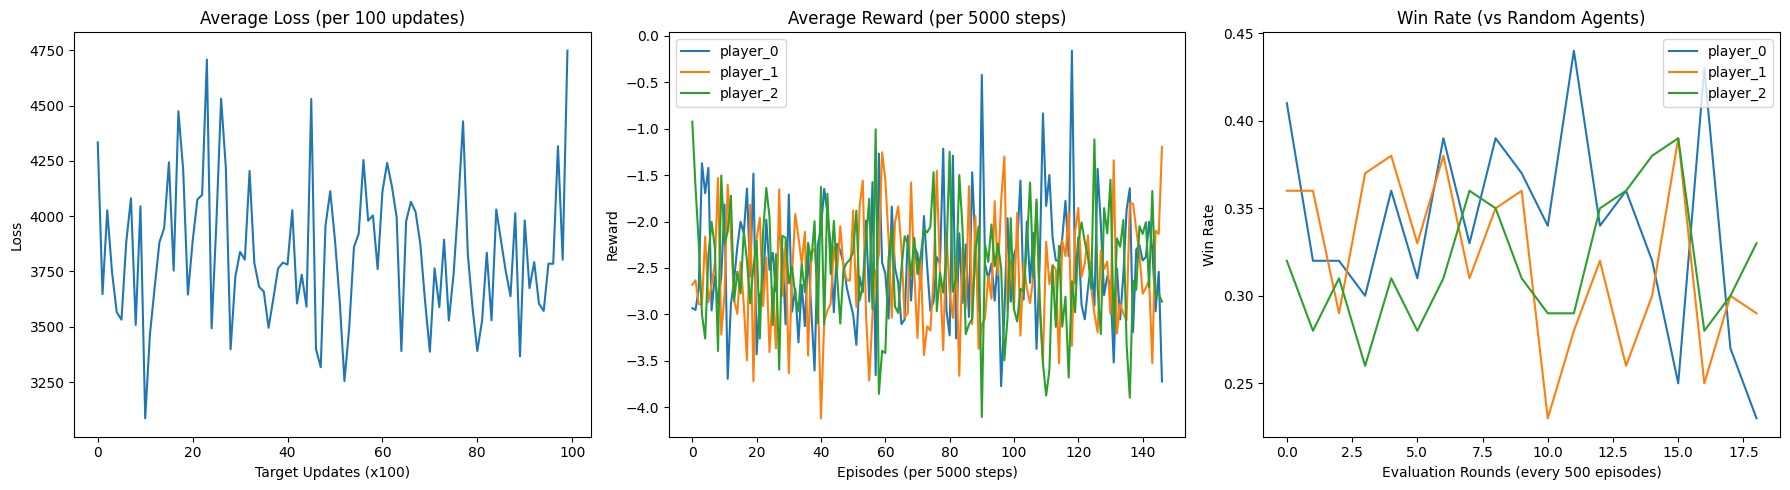

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

# --- Loss Plot ---
axes[0].plot(average_losses)
axes[0].set_title("Average Loss (per 100 updates)")
axes[0].set_xlabel("Target Updates (x100)")
axes[0].set_ylabel("Loss")

# --- Reward Plot ---
for agent_id in average_rewards:
    axes[1].plot(average_rewards[agent_id], label=agent_id)
axes[1].set_title("Average Reward (per 5000 steps)")
axes[1].set_xlabel("Episodes (per 5000 steps)")
axes[1].set_ylabel("Reward")
axes[1].legend()

# --- Win Rate Plot ---
for agent_id in win_rates:
    axes[2].plot(win_rates[agent_id], label=agent_id)
axes[2].set_title("Win Rate (vs Random Agents)")
axes[2].set_xlabel("Evaluation Rounds (every 500 episodes)")
axes[2].set_ylabel("Win Rate")
axes[2].legend()

plt.tight_layout()
plt.show()